Após a construção e avaliação dos modelos baseline, observou-se que há sinal preditivo relevante nos dados (ROC-AUC elevado) , o problema é fortemente desbalanceado e modelos mais complexos não superam automaticamente modelos simples.

Nesse notebook o objetivo é maximizar a captura da classe minoritária, mantendo controle sobre erros, e preparar um modelo robusto.

---



In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

import matplotlib.pyplot as plt

### CARREGANDO OS DADOS

---



In [ ]:
X_train = np.load("X_train.npy")
X_test  = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

print("Shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

Shapes:
X_train: (108090, 30)
X_test:  (36030, 30)
y_train: (108090,)
y_test:  (36030,)


### PIPELINE COM O PCA E A REGRESSÃO LOGÍSTICA

---

*  As variáveis apresentam correlação entre si e modelos baseados em distância e fronteiras lineares sofrem com colinearidade
o PCA permite capturar a maior parte da variância com menos dimensões.

*  Utilizamos a padronização + PCA para redução de ruído e colinearidade , ajustamos o modelo com class_weight penalização do erro na classe minoritária. Otimização de threshold para decisão baseada em recall ou custo para uma avaliação focada na classe 1.




In [ ]:
pipeline_pca = Pipeline(steps=[
    ("scaler", StandardScaler()),# padronizar os dados
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  # Penaliza o erro na classe minoritária
        random_state=42
    ))
])

pipeline_pca

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### TREINAMENTO DO MODELO

---



In [ ]:
pipeline_pca.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### PREDIÇÕES

---



In [ ]:
y_pred = pipeline_pca.predict(X_test)
y_proba = pipeline_pca.predict_proba(X_test)[:, 1]

In [ ]:

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:\n")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     35962
         1.0       0.07      0.91      0.14        68

    accuracy                           0.98     36030
   macro avg       0.54      0.95      0.56     36030
weighted avg       1.00      0.98      0.99     36030

Matriz de Confusão:

[[35197   765]
 [    6    62]]
ROC-AUC: 0.9781


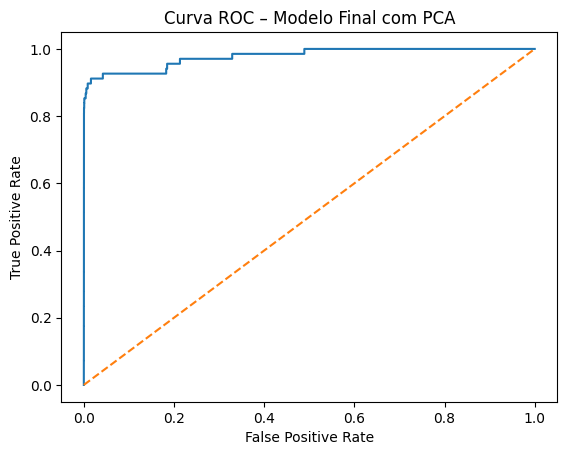

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Modelo Final com PCA")
plt.show()

### PRECISION RECALL CURVE DA CLASSE MINORITÁRIA

---



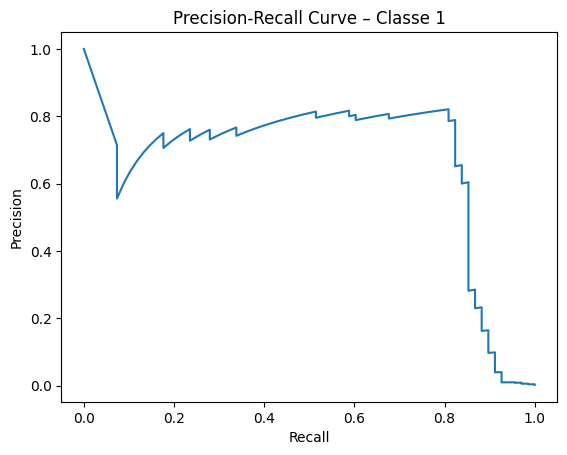

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Classe 1")
plt.show()

### ANÁLISE DO PCA

---



In [ ]:
pca = pipeline_pca.named_steps['pca']

print(f"Número de componentes selecionados: {pca.n_components_}")
print(f"Variância explicada acumulada: {np.sum(pca.explained_variance_ratio_):.2%}")

Número de componentes selecionados: 26
Variância explicada acumulada: 95.90%


Este modelo corrige limitações observadas no baseline pois penaliza a classe minoritária , reduz colinearidade e mantém interpretabilidade e estabilidade , também faremos o threshold de decisão.

In [ ]:
from joblib import dump
dump(pipeline_pca, "modelo_pca_logistico.joblib")


['modelo_pca_logistico.joblib']